### Access Files in Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import required libraries and necessary packages

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [ ]:
#The path of our data on drive
data_dir =  r'/content/drive/My Drive/X-Ray-Image-DataSet'
 
 
#Loading Data
data = load_files(data_dir)

In [ ]:
folders=os.listdir("/content/drive/My Drive/X-Ray-Image-DataSet")
print(folders)

['Covid-19', 'Non Covid-19']


The data set contains two folders, **Covid-19** which contains X-ray images of people  with the virus, the **Non Covid-19** which contains X-ray images of normal people



In [ ]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /content/drive/My Drive/X-Ray-Image-DataSet/Non Covid-19/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


### Convert images to arrays

In [ ]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 150,150 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           150*150 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(625, 150, 150, 3)
First training item :  [[[27. 27. 27.]
  [35. 35. 35.]
  [23. 23. 23.]
  ...
  [22. 22. 22.]
  [22. 22. 22.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [25. 25. 25.]
  [22. 22. 22.]
  ...
  [22. 22. 22.]
  [22. 22. 22.]
  [22. 22. 22.]]

 [[23. 23. 23.]
  [22. 22. 22.]
  [22. 22. 22.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 ...

 [[29. 29. 29.]
  [66. 66. 66.]
  [76. 76. 76.]
  ...
  [58. 58. 58.]
  [66. 66. 66.]
  [67. 67. 67.]]

 [[23. 23. 23.]
  [50. 50. 50.]
  [71. 71. 71.]
  ...
  [55. 55. 55.]
  [70. 70. 70.]
  [76. 76. 76.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [56. 56. 56.]
  ...
  [51. 51. 51.]
  [79. 79. 79.]
  [83. 83. 83.]]]


#### **Note:**
#### The shape of training data is **(625, 150, 150, 3)**
#####  
 
-   625 is the number of training items or files,
-   (224,224) is the target size or image size provided while loading image
-   3 refers to the depth for colored images ( RGB channels ).


### Some pictures

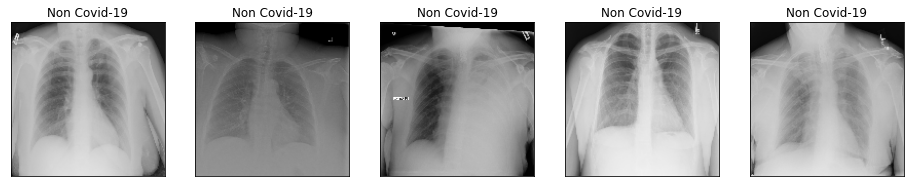

In [ ]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [ ]:
#scaling the pixel intenties to the range[0,255]

X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [ ]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

In [ ]:
# Applying one-hot encoding on the labels

y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([[1., 0.],
       [0., 1.]], dtype=float32)

### Split the data into train, test and valid subsets
 **80% train**, **10% validation**, and **10% test**.

In [ ]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [ ]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (150, 150, 3)


**(150, 150, 3)** refers to the shape of the data (images) that will be fed our CNN

### **CNN Implementation**

#### Building a custom architecture as shown in the image below.


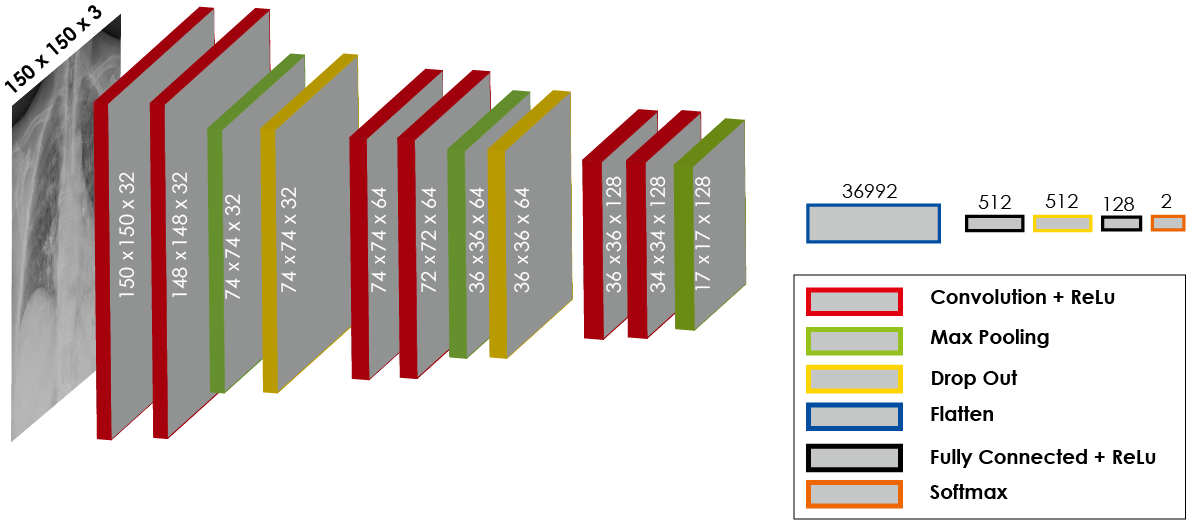

In [ ]:
# Required libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu', name='Dense_1'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', name='Dense_2'))
model.add(Dense(units=no_of_classes, activation='softmax', name='Output'))

### Compile the model
Using the RMSpro optimazer

In [ ]:
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


---

### **Modelling**


In [ ]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Time to train our model !
epochs = 100
batch_size=32

train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,y_train,
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)


checkpointer = ModelCheckpoint("/content/drive/My Drive/heuristic.h5", save_best_only = True, verbose = 1)


start = time.time()

# let's get started !

history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data = validation_generator,
                            verbose=1,
                            steps_per_epoch=len(X_train) // batch_size,
                            validation_steps=len(X_valid) //batch_size, 
                            callbacks=[checkpointer, learning_rate_reduction])

end = time.time()

duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

<ipython-input-19-ef923951adbb>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 2.0931 - accuracy: 0.7265
Epoch 1: val_loss improved from inf to 0.66189, saving model to /content/drive/My Drive/heuristic.h5
15/15 [==============================] - 9s 601ms/step - loss: 2.0931 - accuracy: 0.7265 - val_loss: 0.6619 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7863
Epoch 2: val_loss improved from 0.66189 to 0.54986, saving model to /content/drive/My Drive/heuristic.h5
15/15 [==============================] - 3s 212ms/step - loss: 0.6165 - accuracy: 0.7863 - val_loss: 0.5499 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.7863
Epoch 3: val_loss did not improve from 0.54986
15/15 [==============================] - 3s 175ms/step - loss: 0.6138 - accuracy: 0.7863 - val_loss: 0.6272 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/100
15/15 [===========

### Evaluating

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

2/2 - 1s - loss: 0.1186 - accuracy: 0.9677 - 605ms/epoch - 302ms/step
Accuracy: 96.77%
Loss: 0.1185675635933876


### Accuracy and Loss graphs

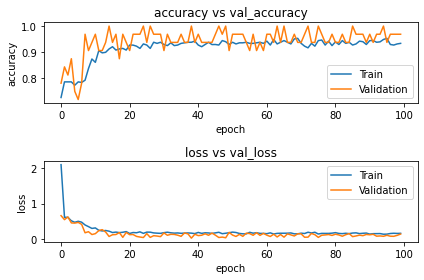

In [ ]:
# Visualizing the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# calling the plot function with the 'result' parameter 
 
plot(history)

**Important Insights :**
- From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!;
- Our Training and Validation Loss graph above also indicates a good learning rate, which is amazing !

---

### **Prediction**
Testing the model on more random samples from the test data !

2/2 [==============================] - 0s 19ms/step


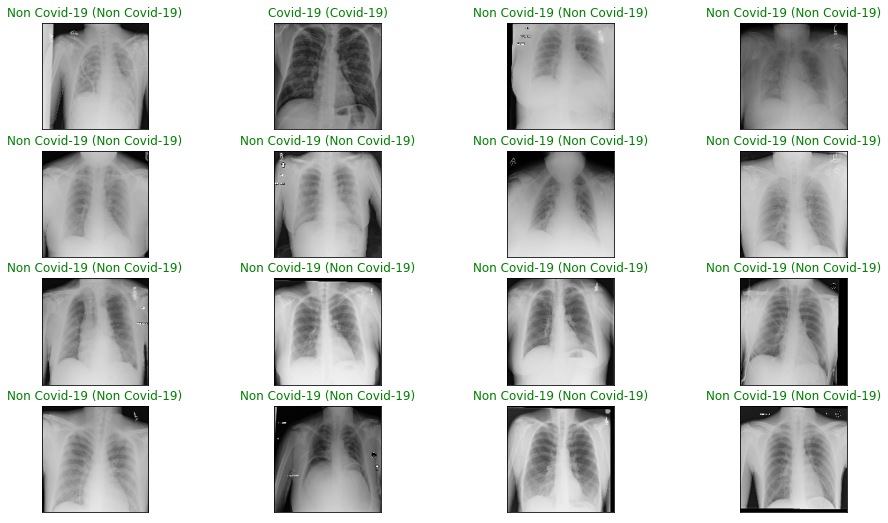

In [ ]:
# Visualizing some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

### Confusion Matrix
Note: **0 and 1 values represent Covid-19 and Non_Covid-19 respectively**

2/2 [==============================] - 0s 19ms/step


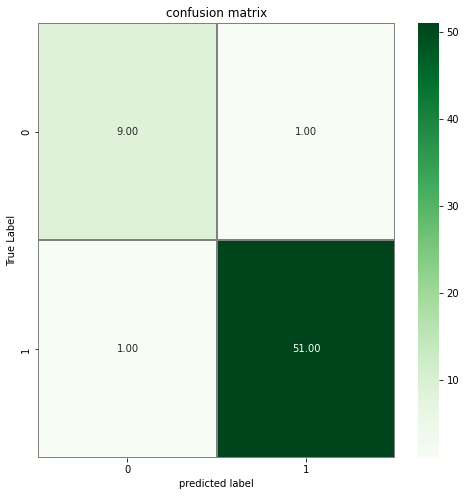

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

**Some Insights:**
- It's easier to detect is **Covid-19**, i.e. if you are infected then you are really infected
- It is clear that the model can sometimes deceive in stating that a person is not infected but it could be. Anyways, we need the expertise to explain this kind of stuff, especially when it comes to medicine. Just we must not forget that we do not have enough images for Covid-19.

- Our confusion matrix indicates that there are disturbing errors. which is Great!.

> You can check the classification report below for more information !

In [ ]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       0.90      0.90      0.90        10
Non Covid-19       0.98      0.98      0.98        52

    accuracy                           0.97        62
   macro avg       0.94      0.94      0.94        62
weighted avg       0.97      0.97      0.97        62



### Loading the model
Loading our best model trained befor, then make some predictions with it !

In [ ]:
my_model=keras.models.load_model("/content/drive/My Drive/heuristic.h5")

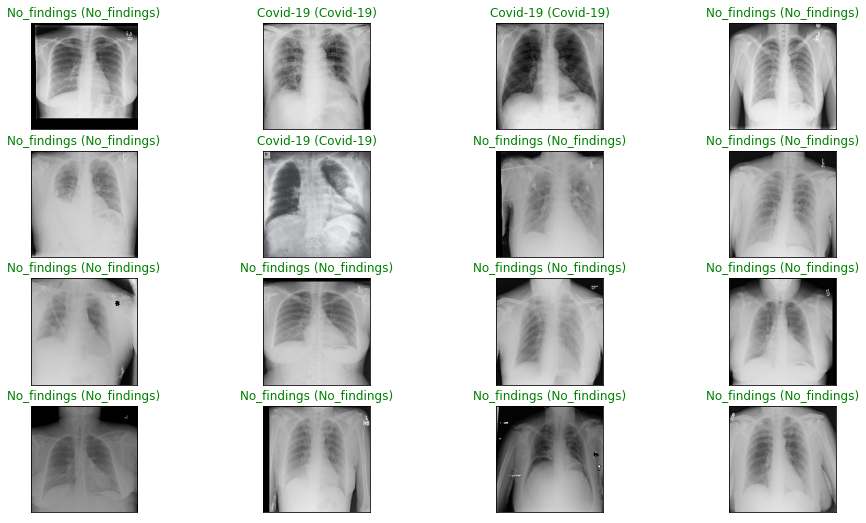

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))